In [33]:
import pandas as pd
import numpy as np
import torch
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
from helpers import performance_plot, resume_backtest, annual_alpha_plot, price_to_perf, last_month, next_friday, prob_to_pred, printmetrics
from sklearn.metrics import classification_report
from models import MLP, GRU, LSTM
from train_test import train, test
from data import get_data

from datetime import datetime
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt


import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

In [18]:
def backtest_strat(features, forward_weekly_returns, hidden_size=10, model_name='MLP',
                   nb_epochs=50, training_window=5, input_period=10, dropout=0.1,
                   batch_size=10, verbose=0, eta=1e-3, weight_decay=0, num_layers=2):

    print('Backtesting model ' + model_name)

    threshold_return_diff = 0.0005

    nbr_features = len(features.columns)

    best_pred = (forward_weekly_returns.SMALL_MID > forward_weekly_returns.LARGE).astype(int)

    # The moving window every 26 weeks
    df_prob_all = pd.DataFrame()
    all_end_dates = ['2015-07-01', '2016-01-01', '2016-07-01', '2017-01-01', 
                     '2017-07-01', '2018-01-01', '2018-07-01', '2019-01-01', 
                     '2019-07-01', '2020-01-01', '2020-07-01', '2021-01-01',
                     '2021-07-01']
    for end_date in tqdm(all_end_dates):

        end_date = datetime.strptime(end_date, '%Y-%m-%d')
        start_date = next_friday(end_date - relativedelta(years=training_window))

        df_output = best_pred.loc[start_date:end_date]

        start_date_test = next_friday(end_date - relativedelta(months=6))
        split_index = df_output.index.get_loc(start_date_test, method='bfill')
        index_test = df_output.iloc[split_index:].index

        features_std = pd.DataFrame(index=df_output.index, 
                                    data=PowerTransformer(method='yeo-johnson', standardize=True).fit_transform(features.reindex(df_output.index)), 
                                    columns=features.columns)

        if model_name == 'MLP':

            df_input = features_std.reindex(df_output.index)

            df_input_train = df_input.iloc[:split_index]
            df_output_train = df_output.iloc[:split_index]
            df_input_test = df_input.iloc[split_index:]
            df_output_test = df_output.iloc[split_index:]

            forward_weekly_returns_train = forward_weekly_returns.reindex(df_output_train.index)
            index_train = list(df_output_train.reset_index()[forward_weekly_returns_train.reset_index().abs_diff > threshold_return_diff].index)
            X_train = df_input_train.values[index_train]
            X_test = df_input_test.values

        else:

            df_input = features_std.loc[:end_date]

            df_output_train = df_output.iloc[:split_index]
            df_output_test = df_output.iloc[split_index:]

            forward_weekly_returns_train = forward_weekly_returns.reindex(df_output_train.index)
            index_train = list(df_output_train.reset_index()[forward_weekly_returns_train.reset_index().abs_diff > threshold_return_diff].index)
            X = []
            for idx in df_output.index:
                df_input_period = df_input.loc[:idx].iloc[-input_period:]
                X_period = df_input_period.values.reshape(input_period, nbr_features)
                X.append(X_period)
            X = np.array(X)
            X_train = X[:split_index]
            X_train = X_train[index_train]
            X_test = X[split_index:]
        y_train = df_output_train.values[index_train]
        y_test = df_output_test.values

        # Transform Numpy arrays to Torch tensors
        X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

        if model_name == 'MLP':
            model = MLP(nbr_features, num_layers=num_layers, hidden_size=hidden_size, pdrop=dropout)
            
        elif model_name == 'GRU':
            model = GRU(nbr_features, hidden_size)

        elif model_name == 'LSTM':
            model = LSTM(nbr_features, hidden_size)

        # Train the model
        train(model, X_train, y_train, nb_epochs=nb_epochs, X_test=X_test, y_test=y_test, 
                batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)
        # Get predictions
        prob = test(model, X_test)
        df_prob = pd.DataFrame(index=index_test, data=prob)
        df_prob_all = pd.concat([df_prob_all, df_prob], axis=0)

    df_prob_all = df_prob_all[~df_prob_all.index.duplicated(keep='first')]
    scaler = MinMaxScaler()
    scaler.fit(df_prob_all.values.reshape(-1, 1))
    signal = scaler.transform(df_prob_all.values.reshape(-1, 1)).reshape(-1)
    return pd.DataFrame(index=df_prob_all.index, data=signal)

def backtest_dl(model_name):
    
    bench_price, target_prices, features = get_data()

    batch_size = 20
    verbose = 0
    training_window = 4

    nb_epochs = 50
    eta = 1e-3
    weight_decay = 1e-4
    dropout = 0.3
    
    hidden_size = 20
    num_layers = 1

    input_period = 21

    forward_weekly_returns = target_prices.rolling(5).apply(lambda x: np.log(x[-1] / x[0]) / len(x)).shift(-5)
    forward_weekly_returns['abs_diff'] = np.abs(forward_weekly_returns.SMALL_MID - forward_weekly_returns.LARGE)


    torch.manual_seed(0)

    df_prob = backtest_strat(features=features, forward_weekly_returns=forward_weekly_returns,
                            model_name=model_name, nb_epochs=nb_epochs,
                            batch_size=batch_size, verbose=verbose, 
                            training_window=training_window, input_period=input_period, dropout=dropout,
                            eta=eta, weight_decay=weight_decay, hidden_size=hidden_size, num_layers=num_layers)

    portfolio = pd.DataFrame(index=df_prob.index, columns=['SMALL_MID', 'LARGE']).fillna(0)
    portfolio['SMALL_MID'] = (df_prob > 0.6).astype(int) - (df_prob < 0.4).astype(int)
    portfolio['LARGE'] = - portfolio.SMALL_MID

    class_type, class_count = np.unique(portfolio.values, axis=0, return_counts=True)
    weights = class_count / sum(class_count)

    benchmark_portfolio = pd.read_excel('data/spiex_spi20_weights.xlsx', index_col=0)
    benchmark_portfolio = benchmark_portfolio.rename(columns={'SPIEX':'SMALL_MID', 'SPI20': 'LARGE'})
    benchmark_portfolio = benchmark_portfolio[['SMALL_MID', 'LARGE']]
    benchmark_portfolio = benchmark_portfolio.reindex(portfolio.index, method='bfill')

    portfolio = portfolio * 0.15 + benchmark_portfolio
    
    return portfolio

In [19]:
def backtest_strat_sklearn(features, forward_weekly_returns, training_window, model_name):

    threshold_return_diff = 0.0005

    nbr_features = len(features.columns)

    best_pred = (forward_weekly_returns.SMALL_MID > forward_weekly_returns.LARGE).astype(int)

    # The moving window every 26 weeks
    df_prob_all = pd.DataFrame()
    all_end_dates = ['2015-07-01', '2016-01-01', '2016-07-01', '2017-01-01', 
                     '2017-07-01', '2018-01-01', '2018-07-01', '2019-01-01', 
                     '2019-07-01', '2020-01-01', '2020-07-01', '2021-01-01',
                     '2021-07-01']
    for end_date in tqdm(all_end_dates):

        end_date = datetime.strptime(end_date, '%Y-%m-%d')
        start_date = next_friday(end_date - relativedelta(years=training_window))

        df_output = best_pred.loc[start_date:end_date]

        start_date_test = next_friday(end_date - relativedelta(months=6))
        split_index = df_output.index.get_loc(start_date_test, method='bfill')
        index_test = df_output.iloc[split_index:].index

        features_std = pd.DataFrame(index=df_output.index, 
                                    data=PowerTransformer(method='yeo-johnson', standardize=True).fit_transform(features.reindex(df_output.index)), 
                                    columns=features.columns)


        df_input = features_std.reindex(df_output.index)

        df_input_train = df_input.iloc[:split_index]
        df_output_train = df_output.iloc[:split_index]
        df_input_test = df_input.iloc[split_index:]
        df_output_test = df_output.iloc[split_index:]

        forward_weekly_returns_train = forward_weekly_returns.reindex(df_output_train.index)
        index_train = list(df_output_train.reset_index()[forward_weekly_returns_train.reset_index().abs_diff > threshold_return_diff].index)
        X_train = df_input_train.values[index_train]
        X_test = df_input_test.values

        y_train = df_output_train.values[index_train]
        y_test = df_output_test.values

        # Transform Numpy arrays to Torch tensors
        X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

        if model_name == 'RF':
            model = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_leaf=1, 
                                           min_samples_split=20, random_state=1)
        elif model_name == 'logreg':
            model = LogisticRegression(penalty='l2', class_weight='balanced')
        

        model.fit(X_train, y_train)
        prob = model.predict_proba(X_test)[:, 1]
        df_prob = pd.DataFrame(index=index_test, data=prob)
        df_prob_all = pd.concat([df_prob_all, df_prob], axis=0)

    df_prob_all = df_prob_all[~df_prob_all.index.duplicated(keep='first')]
    scaler = MinMaxScaler()
    scaler.fit(df_prob_all.values.reshape(-1, 1))
    signal = scaler.transform(df_prob_all.values.reshape(-1, 1)).reshape(-1)
    return pd.DataFrame(index=df_prob_all.index, data=signal)


def backtest_sklearn(model_name):
    
    bench_price, target_prices, features = get_data()

    training_window = 4

    forward_weekly_returns = target_prices.rolling(5).apply(lambda x: np.log(x[-1] / x[0]) / len(x)).shift(-5)
    forward_weekly_returns['abs_diff'] = np.abs(forward_weekly_returns.SMALL_MID - forward_weekly_returns.LARGE)

    df_prob = backtest_strat_sklearn(features=features, forward_weekly_returns=forward_weekly_returns,
                            model_name=model_name, training_window=training_window)

    portfolio = pd.DataFrame(index=df_prob.index, columns=['SMALL_MID', 'LARGE']).fillna(0)
    portfolio['SMALL_MID'] = (df_prob > 0.6).astype(int) - (df_prob < 0.4).astype(int)
    portfolio['LARGE'] = - portfolio.SMALL_MID

    class_type, class_count = np.unique(portfolio.values, axis=0, return_counts=True)
    weights = class_count / sum(class_count)

    benchmark_portfolio = pd.read_excel('data/spiex_spi20_weights.xlsx', index_col=0)
    benchmark_portfolio = benchmark_portfolio.rename(columns={'SPIEX':'SMALL_MID', 'SPI20': 'LARGE'})
    benchmark_portfolio = benchmark_portfolio[['SMALL_MID', 'LARGE']]
    benchmark_portfolio = benchmark_portfolio.reindex(portfolio.index, method='bfill')

    portfolio = portfolio * 0.15 + benchmark_portfolio

    return portfolio

In [20]:
portfolio_mlp = backtest_dl('MLP')

Backtesting model MLP


100%|██████████| 13/13 [00:13<00:00,  1.01s/it]


In [21]:
portfolio_logreg = backtest_sklearn('logreg')

100%|██████████| 13/13 [00:00<00:00, 16.73it/s]


In [22]:
portfolio_RF = backtest_sklearn('RF')

100%|██████████| 13/13 [00:14<00:00,  1.12s/it]


In [38]:
bench_price, target_prices, features = get_data()
daily_returns = target_prices.pct_change()
perf_bench = (bench_price.reindex(portfolio_mlp.index).pct_change().fillna(0) + 1).cumprod()

In [28]:
def pred_to_perf(portfolio, daily_returns):
    first_date = portfolio.index[0]
    last_date = portfolio.index[-1]
    daily_ret = daily_returns.loc[first_date:last_date]
    df_pred_daily = portfolio.reindex(daily_ret.index, method='ffill').shift(1)
    df_daily_perf = (df_pred_daily * daily_ret).sum(axis=1)
    cumul_perf = (1 + df_daily_perf).cumprod()
    return cumul_perf

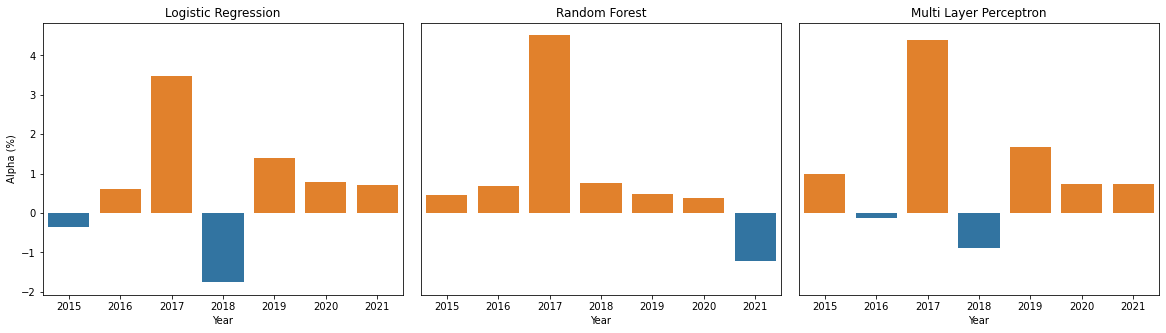

In [55]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharex=True, sharey=True)

# LogReg
perf_pred = pred_to_perf(portfolio_logreg, daily_returns)
annual_returns_bench = perf_bench.resample('Y').apply(lambda x: (x[-1] - x[0]) / x[0])
annual_returns_pred = perf_pred.resample('Y').apply(lambda x: (x[-1] - x[0]) / x[0])
annual_diff = (annual_returns_pred - annual_returns_bench) * 100
df_annual_diff = pd.DataFrame(columns=['year', 'alpha'])
df_annual_diff['year'] = annual_diff.index.year
df_annual_diff['year'] = df_annual_diff.year.apply(str)
df_annual_diff['alpha'] = annual_diff.values
df_annual_diff['sign'] = np.sign(df_annual_diff.alpha)

sns.barplot(ax=axs[0], data=df_annual_diff, x='year', y='alpha', hue='sign', dodge=False)
axs[0].get_legend().remove()
axs[0].set_ylabel('Alpha (%)')
axs[0].set_xlabel('Year')
axs[0].set_title('Logistic Regression')

# RF
perf_pred = pred_to_perf(portfolio_RF, daily_returns)
annual_returns_bench = perf_bench.resample('Y').apply(lambda x: (x[-1] - x[0]) / x[0])
annual_returns_pred = perf_pred.resample('Y').apply(lambda x: (x[-1] - x[0]) / x[0])
annual_diff = (annual_returns_pred - annual_returns_bench) * 100
df_annual_diff = pd.DataFrame(columns=['year', 'alpha'])
df_annual_diff['year'] = annual_diff.index.year
df_annual_diff['year'] = df_annual_diff.year.apply(str)
df_annual_diff['alpha'] = annual_diff.values
df_annual_diff['sign'] = np.sign(df_annual_diff.alpha)

sns.barplot(ax=axs[1], data=df_annual_diff, x='year', y='alpha', hue='sign', dodge=False)
axs[1].get_legend().remove()
axs[1].set_ylabel(None)
axs[1].set_xlabel('Year')
axs[1].tick_params(axis='y', length=0)
axs[1].set_title('Random Forest')

# MLP
perf_pred = pred_to_perf(portfolio_mlp, daily_returns)
annual_returns_bench = perf_bench.resample('Y').apply(lambda x: (x[-1] - x[0]) / x[0])
annual_returns_pred = perf_pred.resample('Y').apply(lambda x: (x[-1] - x[0]) / x[0])
annual_diff = (annual_returns_pred - annual_returns_bench) * 100
df_annual_diff = pd.DataFrame(columns=['year', 'alpha'])
df_annual_diff['year'] = annual_diff.index.year
df_annual_diff['year'] = df_annual_diff.year.apply(str)
df_annual_diff['alpha'] = annual_diff.values
df_annual_diff['sign'] = np.sign(df_annual_diff.alpha)

sns.barplot(ax=axs[2], data=df_annual_diff, x='year', y='alpha', hue='sign', dodge=False)
axs[2].get_legend().remove()
axs[2].set_ylabel(None)
axs[2].tick_params(axis='y', length=0)
axs[2].set_xlabel('Year')
axs[2].set_title('Multi Layer Perceptron')

plt.subplots_adjust(wspace=0.05)
plt.savefig('plots/latex/excess_returns.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()